# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
#!pip -q install ./python 
#!pip install -r requirements.txt

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np 

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
%%time
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.2899999935179949
CPU times: user 776 ms, sys: 204 ms, total: 980 ms
Wall time: 2.65 s


When finished, you can close the environment.

In [6]:
#env.close()
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import os
import time
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
from ddpg_agent import Agent

In [8]:
seed = 0

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.23935318e+00 -1.00000000e+00
  6.78438473e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  7.30195284e-01]


In [10]:
#Create Agent
#agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=seed)
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)

In [11]:
def ddpg(n_episodes=2500, max_t=1200, window_size=100, print_interval=10):
    mean_scores = [] # list of mean scores from each episode
    moving_avgs = [] # list of moving averages
    best_score = -np.inf
    scores_window = deque(maxlen=window_size) # mean score from last 100 episodes
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset environment
        states = env_info.vector_observations # get current state for each observations
        scores = np.zeros(num_agents) # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True) # select an action
            env_info = env.step(actions)[brain_name]  # send all actions to tne environment
            next_states = env_info.vector_observations # get next state (for each agent)
            rewards = env_info.rewards # get reward (for each agent)
            dones = env_info.local_done # see if episode finished
            # perform learning step
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        duration = time.time() - start_time
        mean_scores.append(np.mean(scores)) # save mean score for each episode
        scores_window.append(mean_scores[-1]) # save mean score to window
        moving_avgs.append(np.mean(scores_window)) # save moving average

        print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_window)), end ="")
        if i_episode % print_interval == 0:
#            print("\rEpisode {} ({}s)\tMean: {:.1f}\tMoving Avg: {:.1f}"\
#                  .format(i_episode, round(duration), mean_scores[-1], moving_avgs[-1]))
            print("\rEpisode {} \tMean: {:.1f} \tMoving Avg: {:.1f}"\
                  .format(i_episode, mean_scores[-1], moving_avgs[-1]))
        if moving_avgs[-1] >= 30.0:
            print("\nEnvironment solved in {:d} episodes.\tAverage score: {:.2f}"\
                 .format(i_episode, moving_avgs[-1]))
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
            break
            
    return mean_scores, moving_avgs

In [12]:
%%time
scores, avgs = ddpg(n_episodes=2500, max_t=1200, window_size=100, print_interval=10)

Episode 10 	Mean: 1.5 	Moving Avg: 0.8
Episode 20 	Mean: 1.1 	Moving Avg: 1.0
Episode 30 	Mean: 0.0 	Moving Avg: 1.1
Episode 40 	Mean: 2.4 	Moving Avg: 1.2
Episode 50 	Mean: 2.6 	Moving Avg: 1.3
Episode 60 	Mean: 3.5 	Moving Avg: 1.4
Episode 70 	Mean: 3.1 	Moving Avg: 1.5
Episode 80 	Mean: 3.8 	Moving Avg: 1.7
Episode 90 	Mean: 2.1 	Moving Avg: 1.8
Episode 100 	Mean: 2.4 	Moving Avg: 1.7
Episode 110 	Mean: 2.7 	Moving Avg: 1.9
Episode 120 	Mean: 4.2 	Moving Avg: 2.0
Episode 130 	Mean: 1.0 	Moving Avg: 2.1
Episode 140 	Mean: 1.6 	Moving Avg: 2.2
Episode 150 	Mean: 4.7 	Moving Avg: 2.3
Episode 160 	Mean: 2.7 	Moving Avg: 2.5
Episode 170 	Mean: 3.2 	Moving Avg: 2.6
Episode 180 	Mean: 3.4 	Moving Avg: 2.5
Episode 190 	Mean: 2.4 	Moving Avg: 2.7
Episode 200 	Mean: 1.9 	Moving Avg: 2.9
Episode 210 	Mean: 2.8 	Moving Avg: 3.0
Episode 220 	Mean: 5.2 	Moving Avg: 3.0
Episode 230 	Mean: 3.6 	Moving Avg: 3.1
Episode 240 	Mean: 1.9 	Moving Avg: 3.1
Episode 250 	Mean: 3.3 	Moving Avg: 3.2
Episode 2

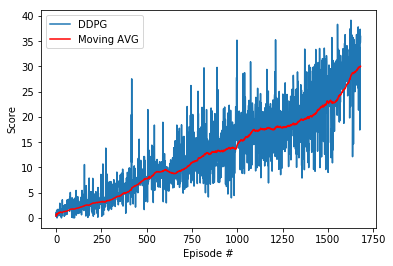

In [13]:
plt.figure()
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [14]:
env.close()

## Report 

#### Learning Algorithm 
Deep Deterministic Policy Gradient or commonly known as DDPG is basically an off-policy method that learns a Q-function and a policy to iterate over actions. It employs the use of off-policy data and the Bellman equation to learn the Q function which is in turn used to derive and learn the policy. (Referred from [here](https://medium.com/analytics-vidhya/demystifying-deep-deterministic-policy-gradient-ddpg-uding-chainerrl-and-openai-baselines-a087a11630cc#:~:text=Deep%20Deterministic%20Policy%20Gradient%20or,derive%20and%20learn%20the%20policy.)) 

DDPG (Lillicrap, et al., 2015), short for Deep Deterministic Policy Gradient, is a model-free off-policy actor-critic algorithm, combining DPG with DQN. Recall that DQN (Deep Q-Network) stabilizes the learning of Q-function by experience replay and the frozen target network. The original DQN works in discrete space, and DDPG extends it to continuous space with the actor-critic framework while learning a deterministic policy. (Referred from [here](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html)) 

DDPG also employs Actor-Critic model in which the Critic model learns the value function like DQN and uses it to determine how the Actor’s policy based model should change. The Actor brings the advantage of learning in continuous actions space without the need for extra layer of optimization procedures required in a value based function while the Critic supplies the Actor with knowledge of the performance. (Referred from [here](https://medium.com/@kinwo/solving-continuous-control-environment-using-deep-deterministic-policy-gradient-ddpg-agent-5e94f82f366d)) 

![DDPG algorithm](DDPG_algo.png "DDPG algorithm")


#### Model architectures

The basic algorithm s an actor-critici method. Policy-based methods using Monte Carlo estimates have high variance problems. TD estimates used in value-based methods have low bias and low variance. Actor critic methods combine these two ideas, the neural network in which the actor renews his or her policies and another neural network in evaluating the policies used to train the actor.

The actor network consists of three fully connected layers with batch normalization applied to the first layer. The network map specifies the behavior. Use the ReLU as an activation function except the last layer with a tanh.

The Critic Network also consists of three fully connected layers with batch normalization applied to the first layer. Map a network map (state, action) pair to the Q-value. The ReLU is used as an activation feature for the first two layers, and there is no activation function for the last layer.

#### Model Parameters

- `state size` = 33
- `action size` = 4
- `number of agents` = 1
- `max time for episode` = 1200s

following parameters implemented from this [repository](https://github.com/ishgirwan/udacity_drlnd/blob/master/Continuous%20control)
- `fc1_units` = 400 
- `fc2_units` = 300 

- `BUFFER_SIZE` = int(1e6) # replay buffer size
- `BATCH_SIZE` = 128 # minibatch size
- `GAMMA` = 0.99 # discount factor
- `TAU` = 1e-3 # for soft update of target parameters
- `LR_ACTOR` = 1e-3 # learning rate of the actor
- `LR_CRITIC` = 1e-3 # learning rate of the critic
- `WEIGHT_DECAY` = 0 # L2 weight decay

- `LEARN_EVERY` = 20 # learning timestep interval
- `LEARN_NUM` = 10 # number of learning passes
- `GRAD_CLIPPING` = 1.0 # gradient clipping
- `OU_SIGMA` = 0.2 # OU noise parameter
- `OU_THETA` = 0.15 # OU noise parameter
- `EPSILON` = 1.0 # for epsilon in the noise process (act step)
- `EPSILON_DECAY` = 1e-6 # epsilon decay rate

#### Idea to improve the performance 
- DDPG can be improved through priority experience regeneration.
- Fine adjustment of the hperparameter can lead to better results and faster training times.
- Multi-agent actor critics in mixed, collaborative competitive environments
- The Q-prop algorithm combined with off-polycy learning and on-polycy learning can be good to try.
- General optimization techniques such as periodic learning speed and warm restart may also be useful.